# <i class="fa-solid fa-brain"></i> EEG Multiverse

*Note: The EEG data for this exercise is not publicly available. If you stumbled across this example outside of the workshop, please head to the [solutions](4_additional/solutions_eeg) for a visual overview. If you did not download the entire book, you can download this individual file as a Jupyter Notebook (.ipynb) file by clicking the download button at the top.*

<iframe width="800" height="450" src="../../_static/placeholder_slides.pdf" frameborder="0" allowfullscreen></iframe>


## The data

Make sure you copy the `data/` folder from the USB stick into the directory of this script.


Starting multiverse analysis for all universes...


  0%|          | 0/64 [00:00<?, ?it/s]

The multiverse analysis completed without any errors.


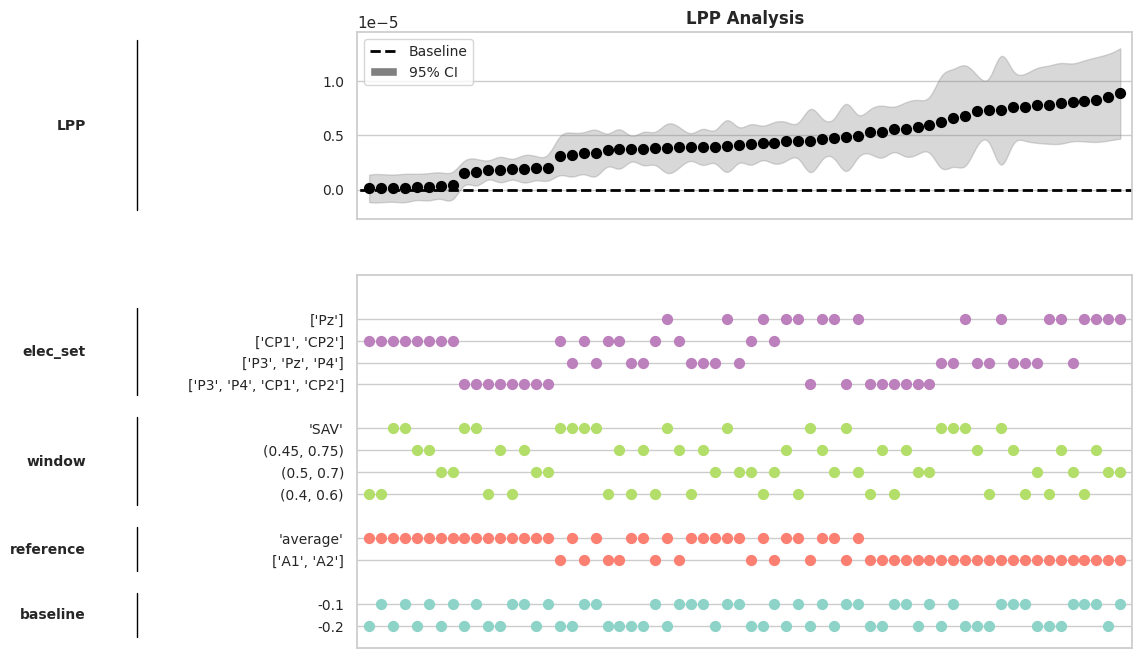

In [1]:
from comet import multiverse

forking_paths = {
    "baseline":  [-0.2, -0.1],
    "reference": [["A1", "A2"], "'average'"], # A1 + A2 are the mastoids
    "window":    [(0.400, 0.600),
                  (0.500, 0.700),
                  (0.450, 0.750),
                  "'SAV'"],
    "elec_set":  [["P3","P4","CP1","CP2"],
                  ["P3","Pz","P4"],
                  ["CP1","CP2"],
                  ["Pz"]]
}

def analysis_template():
    import mne
    import comet
    
    # Suppress warnings
    mne.set_log_level('ERROR')
    import warnings
    warnings.filterwarnings("ignore",module="pymatreader.utils")
    
    lpp_results = []
    subjects = ["21013", "21014", "21015", "21017", "21022"]
    
    for subject in subjects:
        # Load data
        raw = mne.io.read_raw_eeglab(f"data/eeg/{subject}_E4/{subject}_E4_postICA_interpolated_fixed.set", preload=True)
        
        # Epoch data
        event_map = {f"S {i:2d}": i for i in [18,19,28,29,38,39,48,49,56,58,68,69,78,79]}
        events, _ = mne.events_from_annotations(raw, event_id=event_map)
        epochs = mne.Epochs(raw, events, event_id=None, tmin=-0.2, tmax=0.8, baseline=None, preload=True, reject=dict(eeg=150e-6))
        
        # Baseline correction
        epochs.apply_baseline(({{baseline}}, 0))
        
        # Re-reference
        epochs.set_eeg_reference({{reference}})
                
        # Crop (subject average peak or specified window)
        window = {{window}}
        if {{window}} == 'SAV':
            channel, time = epochs.average().get_peak(ch_type='eeg', tmin=0.3, mode='abs')
            epochs.crop(time-0.1, time+0.1)
        else:
            epochs.crop(window[0], window[1])
        
        # Pick electrodes for LPP estimation
        picks = mne.pick_channels(epochs.ch_names, include={{elec_set}}, exclude=[])
        
        # Get LPP as mean amplitude over epochs, channels & timepoints
        data = epochs.get_data() # (n_epochs, n_ch, n_times)
        lpp = data[:, picks, :].mean()
        lpp_results.append(lpp)
    
    # Save results
    comet.utils.save_universe_results({"LPP": lpp_results})

# Create and run the multiverse
mverse = multiverse.Multiverse(name="eeg_multiverse")
mverse.create(analysis_template, forking_paths)
mverse.run(parallel=8)
mverse.specification_curve("LPP", height_ratio=(1, 2), figsize=(10, 8), ci=95, baseline=0, title="LPP Analysis");